In [1]:
import pandas as pd
import sys
import pyspark.sql
from pyspark.sql.types import StructType, StructField, DateType, StringType, DoubleType, TimestampType
from SparkDBUtils import SparkDB
import datetime
from pyspark.sql.functions import current_timestamp
import delta
import matplotlib.pyplot as plt
import scipy

sparkdb = SparkDB()
spark = sparkdb.spark

In [18]:
producto_dim_schema = StructType([
        StructField("date", DateType(), True),
        StructField("product", StringType(), True),
        StructField("product_id", StringType(), True),
        StructField("brand", StringType(), True),
        StructField("price", DoubleType(), True),
        StructField("categories", StringType(), True),
        StructField("unit_price", DoubleType(), True),
        StructField("units", StringType(), True),
        StructField("discount", DoubleType(), True),
        StructField("ts_load", TimestampType(), True)
    ])

dataset = spark.read.option("delimiter", ";").csv("../../dataset/dataset.csv",  schema= producto_dim_schema, header=True)

In [19]:
dataset.head()

Row(date=datetime.date(2022, 11, 21), product='DIA MARI MARINERA langostino cocido 24/32 piezas caja 800 gr', product_id='8456', brand='DIA MARI MARINERA', price=7.99, categories="['Congelados', 'Pescado y marisco']", unit_price=9.99, units='€/Kg.', discount=None, ts_load=None)

In [27]:
dataset = dataset.withColumn("ts_load", current_timestamp())

In [29]:
dataset.summary().show()

+-------+--------------------+------------------+--------------+------------------+--------------------+------------------+---------------+--------+
|summary|             product|        product_id|         brand|             price|          categories|        unit_price|          units|discount|
+-------+--------------------+------------------+--------------+------------------+--------------------+------------------+---------------+--------+
|  count|              258598|            258598|        251175|            258171|              258598|            258171|         258171|       0|
|   mean|                null|184070.27116739505|          null| 3.335872270704507|                null|13.251186732823822|           null|    null|
| stddev|                null| 93759.95093658975|          null|4.6163258336936766|                null| 59.14028297290332|           null|    null|
|    min|1902 licor de gin...|               100|ABADIA DA COVA|              0.15|['Aceites. salsas...|  

In [28]:
dataset.head()

Row(date=datetime.date(2022, 11, 21), product='DIA MARI MARINERA langostino cocido 24/32 piezas caja 800 gr', product_id='8456', brand='DIA MARI MARINERA', price=7.99, categories="['Congelados', 'Pescado y marisco']", unit_price=9.99, units='€/Kg.', discount=None, ts_load=datetime.datetime(2023, 9, 15, 6, 53, 39, 969000))

In [30]:
sparkdb.write_table(dataset, "producto_dia.producto_dim", "append")

# Analisis de la migración

In [2]:
df_producto_dim = spark.table("producto_dia.producto_dim")

In [3]:
df = df_producto_dim.toPandas()

df["date"]  = pd.to_datetime(df["date"])
df["price"]  = df["price"].astype(float)
df["units"]  = df["units"].astype(str)

df.drop(columns=["discount"], inplace=True)

c:\users\carlos\proyectos\foodecommercescraper\venv\lib\site-packages\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302807 entries, 0 to 302806
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   product_id  302807 non-null  object        
 1   product     302807 non-null  object        
 2   brand       295410 non-null  object        
 3   categories  302807 non-null  object        
 4   units       302807 non-null  object        
 5   price       302807 non-null  float64       
 6   unit_price  302807 non-null  float64       
 7   date        302807 non-null  datetime64[ns]
 8   ts_load     302807 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), object(5)
memory usage: 20.8+ MB


# Analisis de campos

In [6]:
df.describe(include="all", datetime_is_numeric=True)

,product_id,product,brand,categories,units,price,unit_price,date,ts_load
count,302807,302807,295410,302807,302807,302807.000000,302807.000000,302807,302807
unique,8482,20429,2395,518,275,NaN,NaN,NaN,NaN
top,162393,Cerveza,DIA,"['Despensa', 'Aperitivos']",€/Kg.,NaN,NaN,NaN,NaN
freq,54,257,8951,9097,130183,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,3.369238,13.440827,2023-02-22 06:58:40.761409024,2023-09-15 07:43:47.030713856
min,NaN,NaN,NaN,NaN,NaN,0.150000,0.010000,2022-11-21 00:00:00,2023-09-12 06:07:46.482290
25%,NaN,NaN,NaN,NaN,NaN,1.590000,2.490000,2022-12-10 00:00:00,2023-09-15 06:59:58.496999936
50%,NaN,NaN,NaN,NaN,NaN,2.450000,6.650000,2023-01-06 00:00:00,2023-09-15 06:59:58.496999936
75%,NaN,NaN,NaN,NaN,NaN,3.850000,13.110000,2023-02-28 00:00:00,2023-09-15 06:59:58.496999936
max,NaN,NaN,NaN,NaN,NaN,305.000000,8764.710000,2023-09-19 00:00:00,2023-09-19 08:54:44.167106


**PRODUCTO**

**NULOS**

In [12]:
nulos = df[df["product"].isna()]

In [13]:
nulos["date"].unique()

array([], dtype='datetime64[ns]')

Borrado de los nulos en tabla

In [14]:
dt = delta.DeltaTable.forName(sparkdb.spark, "producto_dia.producto_dim")

In [15]:
dt.delete("product is null")

**BRAND**

In [12]:
df[df["brand"].isna()]

,product_id,product,brand,categories,units,price,unit_price,date,ts_load
2,74,Pimiento rojo unidad (600 gr aprox.),None,"['Frescos', 'Verduras y hortalizas', 'Tomates....",€/Kg.,1.73,2.89,2022-12-31,2023-09-15 06:59:58.497
85,60753,Boniato unidad (800 gr aprox.),None,"['Frescos', 'Verduras y hortalizas', 'Patatas ...",€/Kg.,1.75,2.19,2022-12-31,2023-09-15 06:59:58.497
123,272355,Pepino unidad (400 gr aprox.),None,"['Frescos', 'Verduras y hortalizas', 'Tomates....",€/Kg.,0.80,1.99,2022-12-31,2023-09-15 06:59:58.497
237,274011,Huevos frescos de gallinas criadas en suelo ca...,None,"['Despensa', 'Lácteos y huevos', 'Huevos']",€/ud.,2.59,0.22,2022-12-31,2023-09-15 06:59:58.497
258,79,Limón unidad (310 gr aprox.),None,"['Frescos', 'Frutas', 'Cítricos']",€/Kg.,0.74,2.39,2022-12-31,2023-09-15 06:59:58.497
...,...,...,...,...,...,...,...,...,...
236183,143306,Cuartos traseros de pollo selección (peso apro...,None,"['Frescos', 'Carne', 'Pollo']",€/Kg.,4.99,4.99,2023-03-11,2023-09-15 06:59:58.497
236252,174324,Manzana Yello bandeja 4 uds,None,"['Frescos', 'Frutas', 'Manzanas']",€/Kg.,1.99,3.62,2023-03-11,2023-09-15 06:59:58.497
236265,40250,Pimientos asados a la leña en tiras bandeja 35...,None,"['Platos preparados', 'Verduras']",€/Kg.,2.75,7.86,2023-03-11,2023-09-15 06:59:58.497
236337,116914,Tomate cherry bandeja 500 gr,None,"['Frescos', 'Verduras y hortalizas', 'Tomates....",€/Kg.,2.39,4.78,2023-03-11,2023-09-15 06:59:58.497


Comprobado por algunos enlaces, que son productos sin Marca. Parecen correctos

**PRICE**

In [15]:
df[df["price"].isna()].sort_values(by="ts_load", ascending=False)

,product_id,product,brand,categories,units,price,unit_price,date,ts_load
18376,289655,GILLETTE Labs máquina de afeitar blíster 1 ud ...,GILLETTE,"['Cuidado personal', 'Afeitado']",None,NaN,NaN,2023-01-12,2023-09-15 06:59:58.497
166861,151270,BONTE acondicionador repara y protege cabello ...,BONTE,"['Cuidado personal', 'Baño e higiene personal'...",None,NaN,NaN,2022-11-26,2023-09-15 06:59:58.497
166615,208693,DIA ambientador automático zen spray 250 ml,DIA,"['Cuidado del hogar', 'Ambientadores']",None,NaN,NaN,2022-11-26,2023-09-15 06:59:58.497
166453,283429,YOPRO batido proteínas sabor chocolate envase ...,YOPRO,"['Bebidas', 'Batidos y horchata']",None,NaN,NaN,2022-11-26,2023-09-15 06:59:58.497
166435,183420,DELICIAS DE DIA espárragos blancos IGP de Nava...,DELICIAS DE DIA,"['Despensa', 'Conservas', 'Conservas vegetales']",None,NaN,NaN,2022-11-26,2023-09-15 06:59:58.497
...,...,...,...,...,...,...,...,...,...
58939,72170,DIA MARI MARINERA filetes de merluza del cabo ...,DIA MARI MARINERA,"['Congelados', 'Pescado y marisco']",None,NaN,NaN,2023-01-25,2023-09-15 06:59:58.497
58875,274986,VEGEDIA postre vegetal de avena con albaricoqu...,VEGEDIA,"['Despensa', 'Lácteos y huevos', 'Yogures']",None,NaN,NaN,2023-01-25,2023-09-15 06:59:58.497
58681,267858,DIA DULCE NOEL roscón de Reyes relleno sabor t...,DIA DULCE NOEL,"['Dulces de navidad', 'Roscones de reyes']",None,NaN,NaN,2023-01-25,2023-09-15 06:59:58.497
58598,109413,DIA zumo naranja 100% exprimido sin pulpa bote...,DIA,"['Bebidas', 'Zumos']",None,NaN,NaN,2023-01-25,2023-09-15 06:59:58.497


Borrado de los productos sin precio

In [16]:
dt = delta.DeltaTable.forName(sparkdb.spark, "producto_dia.producto_dim")

In [18]:
dt.delete("price is null")

Analisis de total de productos unicos por fecha

<AxesSubplot: xlabel='date'>

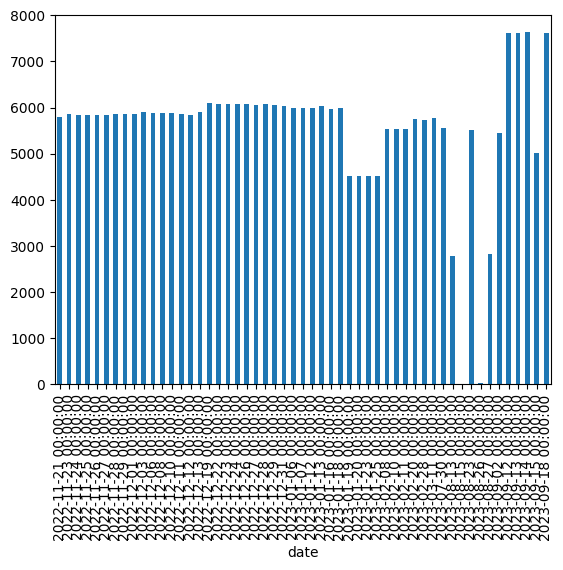

In [14]:
df.groupby("date")["product_id"].agg(pd.Series.nunique).plot(kind="bar")

**DUPLICADOS**

In [15]:
df.groupby(["product_id","ts_load","date"])["product_id"].count().loc[lambda x: x>=2]

Series([], Name: product_id, dtype: int64)

Borrado de los duplicados

In [7]:
dt = delta.DeltaTable.forName(sparkdb.spark, "producto_dia.producto_dim")

In [27]:
dt.delete("product_id = 18013 and ts_load='2023-09-15 06:59:58.497'")

**OUTLIERS**

In [7]:
field = "price"

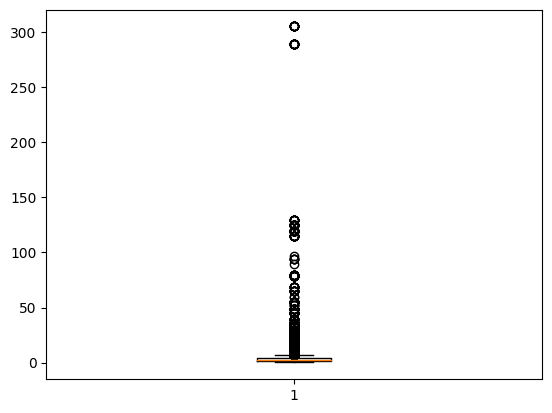

In [8]:
bp = plt.boxplot(df[field])

In [9]:
whiskers = [whisker.get_ydata()[1] for whisker in bp["whiskers"]]
whiskers

[0.15, 7.23]

In [17]:
df[df[field]>whiskers[1]].sort_values(by=field, ascending=True)

,product_id,product,brand,categories,units,price,unit_price,date,ts_load
259809,171264,Colonia corporal,Princesas,"[Perfumería. higiene. salud, Colonias]",€/UNIDAD),7.25,7.25,2023-09-14,2023-09-14 07:13:57.233633
27746,227099,JAENCOOP aceite de oliva virgen extra botella ...,JAENCOOP,"['Despensa', 'Aceites. vinagres y aliños', 'Ac...",€/l.,7.25,7.25,2023-01-13,2023-09-15 06:59:58.497000
35895,188385,CARBONELL aceite de oliva intenso 1º botella 1 lt,CARBONELL,"['Despensa', 'Aceites. vinagres y aliños', 'Ac...",€/l.,7.25,7.25,2023-01-18,2023-09-15 06:59:58.497000
42253,171264,PRINCESAS colonia corporal spray 200 ml,PRINCESAS,"['Cuidado personal', 'Baño e higiene personal'...",€/ud.,7.25,7.25,2023-01-19,2023-09-15 06:59:58.497000
18448,171264,PRINCESAS colonia corporal spray 200 ml,PRINCESAS,"['Cuidado personal', 'Baño e higiene personal'...",€/ud.,7.25,7.25,2023-01-12,2023-09-15 06:59:58.497000
...,...,...,...,...,...,...,...,...,...
266687,197162,Jamón de bellota,Villar,"[Charcutería y quesos, Jamón curado y paleta]",€/KILO),305.00,40.67,2023-09-13,2023-09-13 08:08:48.218044
240971,197162,Jamón de bellota,Villar,"['Charcutería y quesos', 'Jamón curado y paleta']",€/KILO),305.00,40.67,2023-07-30,2023-09-15 06:59:58.497000
302632,197162,Jamón de bellota,Villar,"[Charcutería y quesos, Jamón curado y paleta]",€/KILO),305.00,40.67,2023-09-18,2023-09-18 08:48:51.175760
257597,197162,Jamón de bellota,Villar,"['Charcutería y quesos', 'Jamón curado y paleta']",€/KILO),305.00,40.67,2023-09-02,2023-09-15 06:59:58.497000


<AxesSubplot: ylabel='Density'>

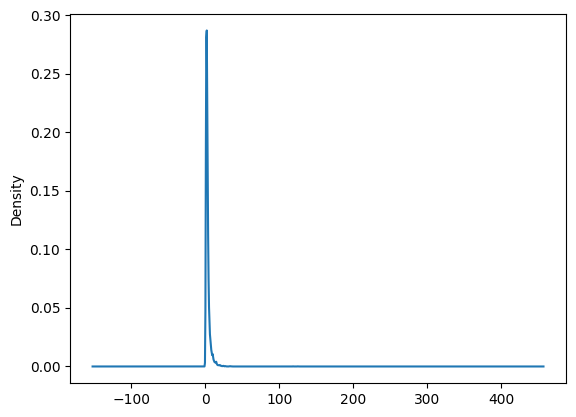

In [11]:
df[field].plot(kind="density")

In [44]:
IQR = df[field].quantile(q=0.75) - df[field].quantile(q=0.25)
out_thr = (IQR * 3) + df[field].quantile(q=0.75)
out_thr

10.629999999999999

In [35]:
df[df[field]>out_thr].sort_values(by=field, ascending=True)

,product_id,product,brand,categories,units,price,unit_price,date,ts_load
279766,228278,Colonia queen of the game,Playboy,"[Perfumería. higiene. salud, Colonias]",€/100 ML.),17.6,19.56,2023-09-12,2023-09-12 07:06:49.901516
282557,228278,Colonia queen of the game Playboy frasco 90 ml,Playboy,"[Perfumería. higiene. salud, Colonias]",€/100 ML.),17.6,19.56,2023-09-19,2023-09-19 07:58:23.772480
48641,182580,SEAGRAM'S ginebra botella 70 cl,SEAGRAM,"['Bodega', 'Alcoholes', 'Ginebra']",€/l.,17.6,25.14,2023-01-20,2023-09-15 06:59:58.497000
290891,228278,Colonia queen of the game,Playboy,"[Perfumería. higiene. salud, Colonias]",€/100 ML.),17.6,19.56,2023-09-18,2023-09-18 08:04:22.742567
246246,228278,Colonia queen of the game,Playboy,"['Perfumería. higiene. salud', 'Colonias']",€/100 ML.),17.6,19.56,2023-08-23,2023-09-15 06:59:58.497000
...,...,...,...,...,...,...,...,...,...
244024,197162,Jamón de bellota,Villar,"['Charcutería y quesos', 'Jamón curado y paleta']",€/KILO),305.0,40.67,2023-08-13,2023-09-15 06:59:58.497000
240971,197162,Jamón de bellota,Villar,"['Charcutería y quesos', 'Jamón curado y paleta']",€/KILO),305.0,40.67,2023-07-30,2023-09-15 06:59:58.497000
296959,197162,Jamón de bellota,Villar,"[Charcutería y quesos, Jamón curado y paleta]",€/KILO),305.0,40.67,2023-09-15,2023-09-15 09:35:42.007339
257597,197162,Jamón de bellota,Villar,"['Charcutería y quesos', 'Jamón curado y paleta']",€/KILO),305.0,40.67,2023-09-02,2023-09-15 06:59:58.497000


In [45]:
df_new = df[df[field]<=out_thr][field]
df_new.describe()

count    293156.000000
mean          2.895524
std           1.893657
min           0.150000
25%           1.590000
50%           2.390000
75%           3.650000
max          10.590000
Name: price, dtype: float64

<AxesSubplot: ylabel='Density'>

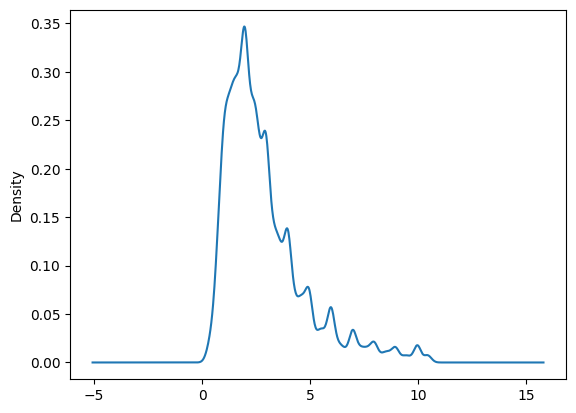

In [46]:
df_new.plot(kind="density")

In [47]:
scipy.stats.normaltest(df_new)

NormaltestResult(statistic=81810.20484564902, pvalue=0.0)